# Create dataframe that can be filtered for different thresholds
There are ~1.6million entries in the results of the direct and reverse approach. This is too much to calculate the CCS score for all vendor-address matches. Therefore we create a value on which we can do prefiltering according to a threshold.   
VA_A = (#𝑣𝑒𝑛𝑑𝑜𝑟−𝑎𝑑𝑑𝑟𝑒𝑠𝑠 𝑚𝑎𝑡𝑐ℎ𝑒𝑠) / (#𝑎𝑑𝑑𝑟𝑒𝑠𝑠 𝑜𝑐𝑐𝑢𝑟𝑠 𝑜𝑣𝑒𝑟𝑎𝑙𝑙)     
VA_V = (#𝑣𝑒𝑛𝑑𝑜𝑟−𝑎𝑑𝑑𝑟𝑒𝑠𝑠 𝑚𝑎𝑡𝑐ℎ𝑒𝑠) / (#𝑎𝑙𝑙 𝑎𝑑𝑑𝑟𝑒𝑠𝑠 𝑚𝑎𝑡𝑐ℎ𝑒𝑠 𝑜𝑓 𝑡ℎ𝑖𝑠 𝑣𝑒𝑛𝑑𝑜𝑟)  

VA_HarmonicMean = (2∗𝑉𝐴_𝐴∗𝑉𝐴_𝑉) / (𝑉𝐴_𝐴+𝑉𝐴_𝑉)

VA_A: 
If low, address most likely has huge indegree and matches many reviews of different vendors by chance  
If high, address is relevant for this vendor  
VA_V: 
If low, either the vendor has many addresses (maybe one per transaction) or the address is less relevant  
If high, the address is more relevant for the vendor  

In [1]:
#import mariadb
import tqdm
import pickle
import pandas as pd
import datetime
from decimal import Decimal
from neo4j import GraphDatabase
from datetime import timedelta
import matplotlib.pyplot as plt

In [3]:
# load matches of both approaches
df_direct = pd.read_csv('direct_results.csv')
df_reverse = pd.read_csv('payout_review_matches2.csv')

In [4]:
# combine the results and take out duplicates (=the address was found in both approaches)
df_direct = df_direct.rename(columns={"review": "ReviewID", 
                                      "vendor": "VendorID", 
                                      "vendor_address": "VendorAddress"})
df_all = pd.concat([df_direct[["ReviewID","VendorID","VendorAddress"]],
                    df_reverse[["ReviewID","VendorID","VendorAddress"]]]).drop_duplicates()
print("Unique addresses in both approaches: ", len(df_direct[df_direct["VendorAddress"].isin(df_reverse["VendorAddress"])]["VendorAddress"].unique()))
print("Resultset of Vendor-Address-Review matches now: ", len(df_all))

Unique addresses in both approaches:  0
Resultset of Vendor-Address-Review matches now:  1925923


In [5]:
#  group on vendor+address & vendor & address
df_all_VA = df_all.groupby(["VendorID","VendorAddress"]).count().reset_index().rename(columns={"ReviewID": "vendor_address_matches"})[["VendorID","VendorAddress","vendor_address_matches"]]
df_all_V =  df_all.groupby(["VendorID"]).count().reset_index().rename(columns={"ReviewID": "all_vendor_matches"})[["VendorID","all_vendor_matches"]]
df_all_A =  df_all.groupby(["VendorAddress"]).count().reset_index().rename(columns={"ReviewID": "all_address_matches"})[["VendorAddress","all_address_matches"]]

In [6]:
# combine counts & calculate relation
df_all_cand = pd.merge(df_all_VA,df_all_V,how='inner',on="VendorID")
df_all_cand = pd.merge(df_all_cand,df_all_A,how='inner', on="VendorAddress" )
df_all_cand["#VA/#A"] = df_all_cand["vendor_address_matches"] / df_all_cand["all_address_matches"]
df_all_cand["#VA/#V"] = df_all_cand["vendor_address_matches"] / df_all_cand["all_vendor_matches"]
df_all_cand["VA_HarmonicMean"] = ( 2 * df_all_cand["#VA/#A"] * df_all_cand["#VA/#V"] )  / ( df_all_cand["#VA/#A"] + df_all_cand["#VA/#V"] )
df_all_cand.sort_values(by="VA_HarmonicMean",ascending=False).head()

,VendorID,VendorAddress,vendor_address_matches,all_vendor_matches,all_address_matches,#VA/#A,#VA/#V,VA_HarmonicMean
929966,12e833597ebf7522b9e1b9e4123f391f,3NAWnfDYtMqi36QBoJP1pvUuuwK81QTRzm,1,1,1,1.0,1.0,1.000000
1428870,3f4c3527fec3eab55f41a193e972f08a,1EYcS4sVzH5ddmGBLMn7t3dg3FMeFQdtBH,1,1,1,1.0,1.0,1.000000
1522767,a3d8528a4b1a657aadad3f93f037f2c1,399WD1MQU7CNpnN3zmePYQ8ZAeVhQGFoMz,1,2,1,1.0,0.5,0.666667
1519990,913e588662f2c0567432b5a9736bc67f,3AariDdHFm4kRZh22EzUi1mDRt1G3wMXXN,1,1,2,0.5,1.0,0.666667
899730,107179581d76c12ece2679738f4ca066,1Kzb4Ao7kP2hpxrPE7g86PtHVM4TZpL6cV,1,2,1,1.0,0.5,0.666667


In [7]:
# store as csv, the threshold can then be applied where the results are loaded so different values can be tried
df_all_cand.to_csv("all_candidates2.csv")

In [8]:
# how many candidates are there all together?
len(df_all_cand)

1648361

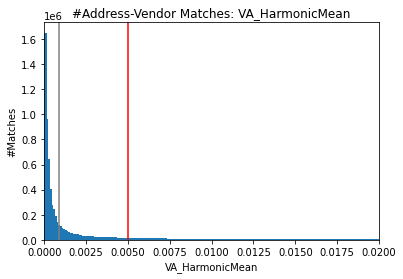

In [9]:
# check for knee value of VA_HarmonicMean
# plot different VA_HarmonicMean values
pd.set_option('precision', 3)
plotlist = list()
xlist = df_all_cand.sort_values(by="VA_HarmonicMean",ascending=True)["VA_HarmonicMean"].round(4).unique()
for X in xlist:
    df_freq_vendoraddresses = df_all_cand[df_all_cand["VA_HarmonicMean"] >= X]
    plotlist.append(len(df_freq_vendoraddresses))
fig, ax = plt.subplots()   
plt.bar(x = xlist, height=plotlist,width=0.0003)
plt.title("#Address-Vendor Matches: VA_HarmonicMean")
plt.xlabel("VA_HarmonicMean")
plt.ylabel("#Matches")
plt.xlim(right=0.02)
plt.xlim(left=0)
plt.axvline(x=0.0009,color='grey')
plt.axvline(x=0.005,color='red')

In [10]:
# how many candidates are there for the knee value?
len(df_all_cand[df_all_cand["VA_HarmonicMean"] >= 0.0009])

108819

In [11]:
# how many candidates are there for another value?
len(df_all_cand[df_all_cand["VA_HarmonicMean"] >= 0.005])

15157

In [12]:
# how many were there originally?
len(df_all_cand)

1648361